In [ ]:
!pip install transformers accelerate opencv-python git+https://github.com/facebookresearch/segment-anything.git
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -O sam_vit_h.pth

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-u8jdj7ef
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-u8jdj7ef
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMG_DIR = "/content/drive/MyDrive/food_dataset/images"
LABEL_DIR = "/content/drive/MyDrive/food_dataset/labels"
FL_JSON_PATH = "/content/food_dataset.florence.json"

Enter the image filename from IMG_DIR (e.g., image1.jpg): 45.jpg
🎯 Florence detection output:
 </s><s>bowl<loc_114><loc_109><loc_970><loc_868><loc_160><loc_578><loc_492><loc_837><loc_169><loc_349><loc_469><loc_567><loc_162><loc_149><loc_449><loc_340>carrot<loc_369><loc_217><loc_423><loc_285><loc_321><loc_230><loc_385><loc_276><loc_196><loc_208><loc_262><loc_253><loc_256><loc_300><loc_321><loc_338><loc_354><loc_276><loc_401><loc_326><loc_181><loc_260><loc_249><loc_293><loc_334><loc_193><loc_393><loc_229><loc_202><loc_291><loc_267><loc_321><loc_276><loc_183><loc_326><loc_212>cucumber<loc_538><loc_343><loc_665><loc_418><loc_503><loc_461><loc_627><loc_539><loc_609><loc_185><loc_716><loc_265><loc_564><loc_380><loc_678><loc_447><loc_531><loc_446><loc_633><loc_520><loc_664><loc_170><loc_768><loc_236><loc_487><loc_248><loc_587><loc_309><loc_686><loc_253><loc_757><loc_334><loc_564><loc_187><loc_626><loc_273><loc_695><loc_310><loc_781><loc_362><loc_457><loc_292><loc_534><loc_343><loc_562><loc_30

/tmp/ipython-input-11-2349185640.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('hsv', len(unique_labels))


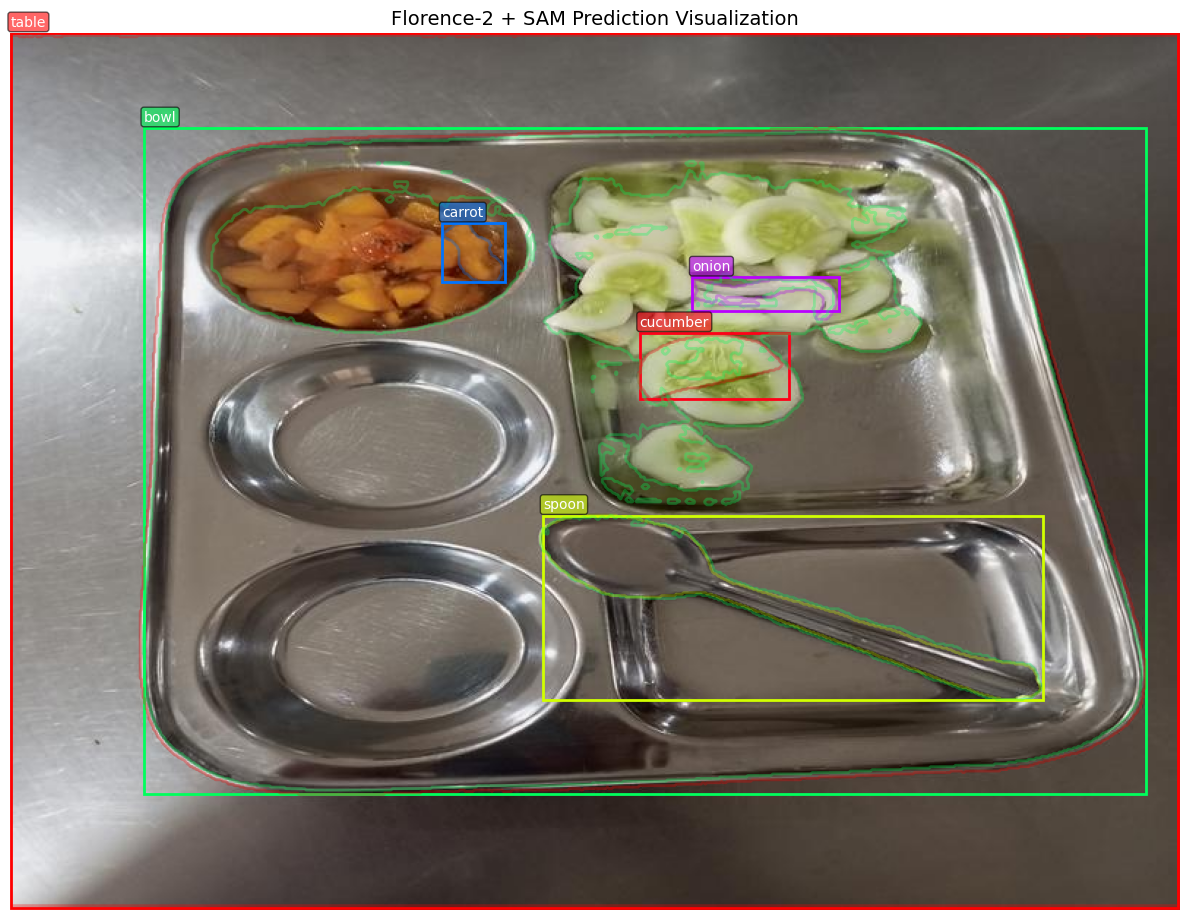

In [ ]:
import os
import re
import csv
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM
from segment_anything import sam_model_registry, SamPredictor
import matplotlib.cm as cm

image_filename = input("Enter the image filename from IMG_DIR (e.g., image1.jpg): ")
image_path = os.path.join(IMG_DIR, image_filename)

image = Image.open(image_path).convert("RGB")
np_image = np.array(image)
img_w, img_h = image.size

device = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base", trust_remote_code=True).to(device)
model.eval()

inputs = processor(images=image, text="<OD>", return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model.generate(**inputs, max_new_tokens=256)
decoded = processor.batch_decode(outputs, skip_special_tokens=False)[0]
print("🎯 Florence detection output:\n", decoded)

def parse_boxes(decoded_text, img_size):
    preds = []
    pattern = r"(\w+)(<loc_\d+><loc_\d+><loc_\d+><loc_\d+>)"
    matches = re.findall(pattern, decoded_text)
    w, h = img_size
    for label, locs in matches:
        nums = list(map(int, re.findall(r"\d+", locs)))
        if len(nums) == 4:
            x1 = nums[0] / 1000 * w
            y1 = nums[1] / 1000 * h
            x2 = nums[2] / 1000 * w
            y2 = nums[3] / 1000 * h
            preds.append({"label": label, "box": [x1, y1, x2, y2]})
    return preds

boxes = parse_boxes(decoded, (img_w, img_h))
print("🗂️ Parsed boxes:", boxes)

sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h.pth").to(device)
predictor = SamPredictor(sam)
predictor.set_image(np_image)

masks = []
for b in boxes:
    box = torch.tensor(b["box"], dtype=torch.int).unsqueeze(0).to(device)
    tbox = predictor.transform.apply_boxes_torch(box, np_image.shape[:2])
    mask, _, _ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=tbox,
        multimask_output=False
    )
    mask_np = mask.squeeze().cpu().numpy()
    if mask_np.ndim == 2:
        masks.append((mask_np, b["label"], b["box"]))
    else:
        print(f"⚠️ Skipped mask for {b['label']} due to invalid shape: {mask_np.shape}")

csv_filename = "florence2_predictions.csv"
with open(csv_filename, mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["image", "label", "x1", "y1", "x2", "y2"])
    for _, label, box in masks:
        x1, y1, x2, y2 = map(int, box)
        writer.writerow([image_filename, label, x1, y1, x2, y2])
print(f"✅ Predictions saved to {csv_filename}")

unique_labels = list(set([label for _, label, _ in masks]))
label_colors = {}
color_map = cm.get_cmap('hsv', len(unique_labels))
for idx, label in enumerate(unique_labels):
    label_colors[label] = color_map(idx)

fig, ax = plt.subplots(1, figsize=(12, 12))
ax.imshow(np_image)

for mask, label, box in masks:
    color = label_colors[label]
    rgba_color = tuple(color[:3]) + (0.3,)
    x1, y1, x2, y2 = map(int, box)

    ax.contour(mask, colors=[rgba_color], linewidths=2)

    ax.add_patch(patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1,
        edgecolor=color[:3],
        facecolor='none',
        linewidth=2
    ))

    ax.text(x1, y1 - 5, label, color='white', fontsize=10,
            bbox=dict(facecolor=color[:3], alpha=0.6, boxstyle='round,pad=0.2'))

plt.title("Florence-2 + SAM Prediction Visualization", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
from google.colab import files

# Upload a file manually
uploaded = files.upload()

# Access the uploaded file
for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")

Saving florence2_labels_output.json to florence2_labels_output.json
Uploaded file: florence2_labels_output.json


In [ ]:
import json

with open(filename, "r") as f:
    florence_outputs = json.load(f)

# Check sample format
print(florence_outputs[:1] if isinstance(florence_outputs, list) else list(florence_outputs.items())[:1])

[{'image': '302_jpg.rf.fd883592398ff3df138d8862d7cdadba.jpg', 'labels': ['Dal', 'Salad', 'Roti']}]


In [ ]:
import json
import re

# Load GT data
with open("florence2_labels_output.json", "r") as f:
    gt_data = json.load(f)

# Extract predicted labels from Florence output
pred_labels = set(label.lower() for _, label, _ in masks)

# Extract image ID like '302' from Florence image filename
image_id = re.split(r'[_\.]', image_filename)[0]

# Find matching GT entry
gt_labels = set()
matched_img = None
for entry in gt_data:
    if entry["image"].startswith(image_id):
        gt_labels = set(label.lower() for label in entry["labels"])
        matched_img = entry["image"]
        break

if not gt_labels:
    print(f"⚠️ No ground truth found for image ID: {image_id}")
else:
    # Compute intersection
    correct_preds = pred_labels.intersection(gt_labels)
    total_gt = len(gt_labels)
    correct = len(correct_preds)

    # Calculate custom accuracy
    accuracy = correct / total_gt if total_gt else 0.0

    print("\n📊 Florence-2 Simple Class Accuracy:")
    print(f"🖼️ Image: {image_filename} matches GT: {matched_img}")
    print(f"✅ Predicted: {sorted(pred_labels)}")
    print(f"📌 Ground Truth: {sorted(gt_labels)}")
    print(f"🎯 Correct Predictions: {sorted(correct_preds)}")
    print(f"📏 Accuracy = {correct}/{total_gt} = {accuracy:.4f}")


📊 Florence-2 Simple Class Accuracy:
🖼️ Image: 45.jpg matches GT: 456_jpg.rf.407a6cec6bf8f7b271ee9ff9f46a5da3.jpg
✅ Predicted: ['bowl', 'carrot', 'cucumber', 'onion', 'spoon', 'table']
📌 Ground Truth: ['dal', 'jamun', 'paneer', 'rice', 'salad']
🎯 Correct Predictions: []
📏 Accuracy = 0/5 = 0.0000
